# Spotify Songs: exploratory data analysis and modeling

This is projected aimed at providing a tool for predicting how successful a song will be based on its audio features, and other engineered features we will be looking at and adding to the models. The first part of the project looks at doing data cleaning on the dataset that we have available, and then we look at feature engineering: song similarity to others, the geospatial aspect of the songs, visualizing the audio features and how they change with different groups of songs. Then, we turn to building models, starting with preparing the data for the linear model, after which we fit and refine a non-parametric model, based on the r2 and mean squared error metrics of how they are performing.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df_data = pd.read_csv('tracks.csv')
len(df_data.index)

586672

In [4]:
sorted_df = df_data.sort_values('popularity', ascending = False).head(100)
sorted_two_df = df_data.sort_values('popularity', ascending = True)
date = list(df_data.release_date)
for i in range(len(date)):
    date[i] = int(date[i][:4])

In [5]:
df_data['Year'] = date

In [6]:
df_pre90 = df_data[df_data.Year <= 1990]
df_post_90 = df_data[df_data.Year > 1990]

In [7]:
sorted_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
93802,4iJyoBOLtHqaGxP12qzhQI,Peaches (feat. Daniel Caesar & Giveon),100,198082,1,"['Justin Bieber', 'Daniel Caesar', 'Giveon']","['1uNFoZAHBGtllmzznpCI3s', '20wkVLutqVOYrc0kxF...",2021-03-19,0.677,0.696,0,-6.181,1,0.1190,0.3210,0.000000,0.420,0.464,90.030,4
93803,7lPN2DXiMsVn7XUKtOW1CS,drivers license,99,242014,1,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],2021-01-08,0.585,0.436,10,-8.761,1,0.0601,0.7210,0.000013,0.105,0.132,143.874,4
93804,3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,98,132780,0,['Masked Wolf'],['1uU7g3DNSbsu0QjSEqZtEd'],2021-01-06,0.778,0.695,4,-6.865,0,0.0913,0.1750,0.000000,0.150,0.472,149.996,4
92810,5QO79kh1waicV47BqGRL3g,Save Your Tears,97,215627,1,['The Weeknd'],['1Xyo4u8uXC1ZmMpatF05PJ'],2020-03-20,0.680,0.826,0,-5.487,1,0.0309,0.0212,0.000012,0.543,0.644,118.051,4
92811,6tDDoYIxWvMLTdKpjFkc1B,telepatía,97,160191,0,['Kali Uchis'],['1U1el3k54VvEUzo3ybLPlM'],2020-12-04,0.653,0.524,11,-9.016,0,0.0502,0.1120,0.000000,0.203,0.553,83.970,4


# Data Cleaning 

Let's do some preliminary exploration on the data. First of all, what type of records does it contain? How are the values for each record obtained? It appears that the name column contains individual songs and their respective names. In the rest of the data features, we can see durations, popularities and other audio features. Let's examine if any of these contain weird values that shouldn't be there, starting with the durations.

In [8]:
sorted_df['duration_ms'].value_counts().index.unique()

Int64Index([170813, 203064, 205090, 198082, 239836, 166794, 196653, 243837,
            289933, 130014, 261493, 204347, 247308, 192956, 132833, 165926,
            215280, 183624, 140942, 123263, 207481, 222523, 190476, 163208,
            173333, 214621, 207133, 198040, 169333, 208827, 211467, 245426,
            232253, 178627, 157606, 240051, 240133, 175721, 212093, 176840,
            312820, 233713, 272394, 269560, 185487, 194088, 209438, 208907,
            189486, 200186, 216107, 154998, 226987, 218107, 156945, 167903,
            186133, 172325, 116750, 203201, 279204, 161385, 261667, 242014,
            169153, 232853, 198371, 164000, 200040, 242096, 160191, 215627,
            132780, 174000, 162803, 169266, 199054, 186088, 227395, 215508,
            190779, 174321, 240400, 174760, 187541, 182161, 155884, 165507,
            178154, 150053, 215891, 166028, 160000, 181733, 173711, 178947,
            243773],
           dtype='int64')

In [9]:
print(max(sorted_df['duration_ms'].value_counts().index.unique()), min(sorted_df['duration_ms'].value_counts().index.unique()))

312820 116750


The miliseconds perhaps is hard to understand, so we'll convert this into minutes and seconds instead:

In [10]:
def minutes_seconds(x):
    to_seconds = x/1000
    to_minutes = to_seconds/60
    return to_minutes

sorted_df['duration_minutes'] = sorted_df['duration_ms'].map(minutes_seconds)
sorted_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_minutes
93802,4iJyoBOLtHqaGxP12qzhQI,Peaches (feat. Daniel Caesar & Giveon),100,198082,1,"['Justin Bieber', 'Daniel Caesar', 'Giveon']","['1uNFoZAHBGtllmzznpCI3s', '20wkVLutqVOYrc0kxF...",2021-03-19,0.677,0.696,...,-6.181,1,0.1190,0.3210,0.000000,0.420,0.464,90.030,4,3.301367
93803,7lPN2DXiMsVn7XUKtOW1CS,drivers license,99,242014,1,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],2021-01-08,0.585,0.436,...,-8.761,1,0.0601,0.7210,0.000013,0.105,0.132,143.874,4,4.033567
93804,3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,98,132780,0,['Masked Wolf'],['1uU7g3DNSbsu0QjSEqZtEd'],2021-01-06,0.778,0.695,...,-6.865,0,0.0913,0.1750,0.000000,0.150,0.472,149.996,4,2.213000
92810,5QO79kh1waicV47BqGRL3g,Save Your Tears,97,215627,1,['The Weeknd'],['1Xyo4u8uXC1ZmMpatF05PJ'],2020-03-20,0.680,0.826,...,-5.487,1,0.0309,0.0212,0.000012,0.543,0.644,118.051,4,3.593783
92811,6tDDoYIxWvMLTdKpjFkc1B,telepatía,97,160191,0,['Kali Uchis'],['1U1el3k54VvEUzo3ybLPlM'],2020-12-04,0.653,0.524,...,-9.016,0,0.0502,0.1120,0.000000,0.203,0.553,83.970,4,2.669850


Now we can take a look at how the song durations are distributed, and they seem like they form a left-skewed histogram, which more values at about 3 minutes. This prompts us to ask why songs tend to be shorter.

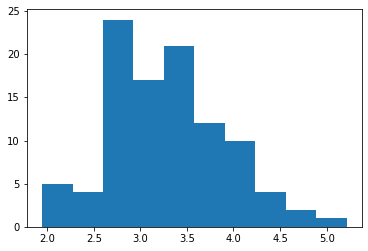

In [11]:
plt.hist(sorted_df['duration_minutes']);

There are other features we want to understand, such as time signature. It is not immediately apparent what this means, so let's look at what values it contains, and it turns out it has either 3,4 or 5 as its values.

In [12]:
sorted_df['time_signature'].value_counts().index.unique()

Int64Index([4, 3, 5], dtype='int64')

Below, you can see the entire list of columns in this dataframe. One that is also hard to understand at first is "key". Looking at its values, it appears to have integers from 0 to 11. What does that correspond to?

In [13]:
sorted_df.columns

Index(['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'duration_minutes'],
      dtype='object')

In [14]:
sorted_df['key'].unique()

array([ 0, 10,  4, 11,  5,  1,  8,  2,  6,  7,  9,  3])

Now let's look at the "artists" column, which is a Series with a list for each artist in a particular song, and the song columns. Are there any weird values here?

In [15]:
sorted_df['artists'][:10]

93802      ['Justin Bieber', 'Daniel Caesar', 'Giveon']
93803                                ['Olivia Rodrigo']
93804                                   ['Masked Wolf']
92810                                    ['The Weeknd']
92811                                    ['Kali Uchis']
93805    ['Bruno Mars', 'Anderson .Paak', 'Silk Sonic']
92813                                    ['The Weeknd']
92814                                        ['Tiësto']
92816                                        ['Giveon']
92819                           ['Myke Towers', 'Juhn']
Name: artists, dtype: object

In [16]:
sorted_df['artists'].unique()

array(["['Justin Bieber', 'Daniel Caesar', 'Giveon']",
       "['Olivia Rodrigo']", "['Masked Wolf']", "['The Weeknd']",
       "['Kali Uchis']", "['Bruno Mars', 'Anderson .Paak', 'Silk Sonic']",
       "['Tiësto']", "['Giveon']", "['Myke Towers', 'Juhn']",
       "['Riton', 'Nightcrawlers', 'Mufasa & Hypeman', 'Dopamine']",
       "['Los Legendarios', 'Wisin', 'Jhay Cortez']", "['Doja Cat']",
       "['The Kid LAROI']", "['SZA']", "['Bad Bunny', 'ROSALÍA']",
       "['Nathan Evans', '220 KID', 'Billen Ted']",
       "['Bad Bunny', 'Jhay Cortez']", "['Ariana Grande']", "['Boza']",
       "['MEDUZA', 'Dermot Kennedy']", "['Justin Bieber']", "['Cardi B']",
       "['Rochy RD', 'Myke Towers', 'Nicki Nicole']", "['Harry Styles']",
       "['Travis Scott', 'HVME']", "['Tate McRae']", "['BTS']",
       "['KAROL G']", "['DaBaby', 'Roddy Ricch']", "['Pop Smoke']",
       "['Joel Corry', 'MNEK']", "['Sech']", "['ATB', 'Topic', 'A7S']",
       "['Drake']", "['Dua Lipa']", "['Saweetie', 'Doja Cat

In [17]:
len(sorted_df['name'].unique()) == len(sorted_df['name'])

False

Interestingly, a quick check that all of the songs are unique (i.e. songs appear only once in the dataframe), turns out to be false. That is, there could be duplicate songs, which we need to clean before we proceed. From below, it seems that there are 97 unique songs, but 100 songs in total in the dataframe. We can do this by grouping and sorting by the count. There are three songs that appear 2 times each, instead of 1 time as they should.

In [18]:
len(sorted_df['name'].unique())

97

In [19]:
len(sorted_df['name'])

100

In [20]:
sorted_df.groupby(['name']).size().sort_values(ascending = False)

name
DÁKITI                                                2
Levitating (feat. DaBaby)                             2
Hold On                                               2
34+35                                                 1
Roses - Imanbek Remix                                 1
                                                     ..
GIRL LIKE ME                                          1
Friday (feat. Mufasa & Hypeman) - Dopamine Re-Edit    1
For The Night (feat. Lil Baby & DaBaby)               1
Film out                                              1
you broke me first                                    1
Length: 97, dtype: int64

In [21]:
sorted_df[sorted_df['name'] == 'DÁKITI']

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_minutes
92824,47EiUVwUp4C9fGccaPuUCS,DÁKITI,92,205090,1,"['Bad Bunny', 'Jhay Cortez']","['4q3ewBCX7sLwd24euuV69X', '0EFisYRi20PTADoJri...",2020-10-30,0.731,0.573,...,-10.059,0,0.0544,0.401,0.000052,0.113,0.145,109.928,4,3.418167
92847,4MzXwWMhyBbmu6hOcLVD49,DÁKITI,90,205090,1,"['Bad Bunny', 'Jhay Cortez']","['4q3ewBCX7sLwd24euuV69X', '0EFisYRi20PTADoJri...",2020-11-27,0.731,0.573,...,-10.059,0,0.0544,0.401,0.000052,0.113,0.145,109.928,4,3.418167


In [22]:
sorted_df[sorted_df['name'] == 'Levitating (feat. DaBaby)']

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_minutes
92843,463CkQjx2Zk1yXoBuierM9,Levitating (feat. DaBaby),90,203064,0,"['Dua Lipa', 'DaBaby']","['6M2wZ9GZgrQXHCFfjv46we', '4r63FhuTkUYltbVAg5...",2020-10-01,0.702,0.825,...,-3.787,0,0.0601,0.00883,0.0,0.0674,0.915,102.977,4,3.3844
92867,5nujrmhLynf4yMoMtj8AQF,Levitating (feat. DaBaby),89,203064,0,"['Dua Lipa', 'DaBaby']","['6M2wZ9GZgrQXHCFfjv46we', '4r63FhuTkUYltbVAg5...",2020-03-27,0.702,0.825,...,-3.787,0,0.0601,0.00883,0.0,0.0674,0.915,102.977,4,3.3844


In [23]:
sorted_df[sorted_df['name'] == 'Hold On']

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_minutes
93811,4u4NyuceXP7Uzh7XFJKCr1,Hold On,92,170813,0,['Justin Bieber'],['1uNFoZAHBGtllmzznpCI3s'],2021-03-05,0.658,0.634,...,-5.797,0,0.0413,0.0106,0.0,0.132,0.290,139.980,4,2.846883
93838,1nahzW3kfMuwReTka28tH5,Hold On,88,170813,0,['Justin Bieber'],['1uNFoZAHBGtllmzznpCI3s'],2021-03-19,0.658,0.634,...,-6.068,0,0.0431,0.0104,0.0,0.120,0.302,140.002,4,2.846883


We need to decide how to deal with these, especially as each of these has a different popularity score for the same song, which is impossible when ranking the top 100 songs. Let's first look at the values in the popularity column. So it does look like the values don't go from 1 to 100, as we previously assumed. Instead, they go from 87 to 100. 87 seems arbitrary, so let's look a bit more into that. It is hard to tell from this one dataframe what could be going wrong, but there are some clues in the "release_date" column.

In [24]:
sorted_df.sort_values('popularity', ascending = True).head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_minutes
78355,2Lhdl74nwwVGOE2Gv35QuK,Cupid's Chokehold / Breakfast in America,87,243773,0,['Gym Class Heroes'],['4IJczjB0fJ04gs4uvP0Fli'],2005-02-22,0.720,0.744,...,-6.938,0,0.1200,0.23700,0.000000,0.2550,0.619,78.953,4,4.062883
86017,3U4isOIWM3VvDubwSI3y7a,All of Me,87,269560,0,['John Legend'],['5y2Xq6xcjJb2jVM54GHK3t'],2013-08-30,0.422,0.264,...,-7.064,1,0.0322,0.92200,0.000000,0.1320,0.331,119.930,4,4.492667
86018,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,87,272394,0,['Arctic Monkeys'],['7Ln80lUS6He07XvHI8qqHH'],2013-09-09,0.548,0.532,...,-7.596,1,0.0323,0.18600,0.000263,0.2170,0.405,85.030,4,4.539900
89912,7qiZfU4dY1lWllzX7mPBI3,Shape of You,87,233713,0,['Ed Sheeran'],['6eUKZXaKkcviH0Ku9w2n3V'],2017-03-03,0.825,0.652,...,-3.183,0,0.0802,0.58100,0.000000,0.0931,0.931,95.977,4,3.895217
90906,2xLMifQCjDGFmkHkpNLD9h,SICKO MODE,87,312820,1,['Travis Scott'],['0Y5tJX1MQlPlqiwlOH1tJY'],2018-08-03,0.834,0.730,...,-3.714,1,0.2220,0.00513,0.000000,0.1240,0.446,155.008,4,5.213667


In [25]:
sorted_df['popularity'].unique()

array([100,  99,  98,  97,  96,  95,  94,  93,  92,  91,  90,  89,  88,
        87])

In [26]:
max(sorted_df['release_date'])

'2021-04-09'

In [27]:
min(sorted_df['release_date'])

'2005-02-22'

The dates aren't from the same year, so this could be some merging together of different songs from various years, which might have been popular when they were released. Here is a plot of the dates, which is slightly unclear to see, so we will process that now by only extracting the year.

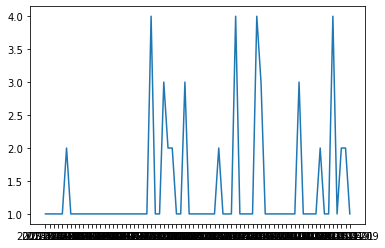

In [28]:
y = sorted_df.groupby(['release_date']).count()['id'].values
plt.plot(sorted_df.groupby(['release_date']).count().index, y)

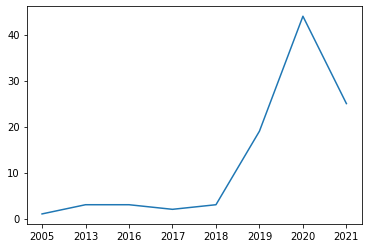

In [29]:
years = sorted_df['release_date'].map(lambda x: x[:4])
sorted_df['year'] = years
y = sorted_df.groupby(['year']).count()['id'].values
plt.plot(sorted_df.groupby(['year']).count().index, y)

Now that we have a much clearer plot, there is some extra insight in the data. It seems like the majority of the songs are from 2020, but there are a few from other years as well. It is unclear how those got there, but the popularity column seems a bit useless now. So we can simply pick one of the duplicated songs to keep in the dataframe.

In [30]:
sorted_df_fixed = sorted_df.groupby(['name'], as_index=False).agg(lambda x: x.iloc[0]).index
#sorted_df_fixed = sorted_df.set_index('name')[sorted_df_fixed]
#sorted_df.set_index('name')
#sorted_df.loc[sorted_df_fixed, :]
sorted_df_fixed

RangeIndex(start=0, stop=97, step=1)

Now we can go on to the sorted_two_df dataframe, and examine the data there.

In [31]:
sorted_two_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
546130,181rTRhCcggZPwP2TUcVqm,"Newspaper Reports On Abner, 20 February 1935",0,896575,0,"['Norris Goff', 'Chester Lauck', 'Carlton Bric...","['3WCwCPDMpGzrt0Qz6quumy', '7vk8UqABg0Sga78GI3...",1935-02-20,0.595,0.262,8,-17.746,1,0.9320,0.993,0.007510,0.0991,0.320,79.849,4
546222,0yOCz3V5KMm8l1T8EFc60i,恋は水の上で,0,188440,0,['Hibari Misora'],['1m5pMY5blqJwdxJ7vqQtuN'],1949,0.418,0.388,0,-8.580,1,0.0358,0.925,0.000014,0.1050,0.439,94.549,4
546221,0y48Hhwe52099UqYjegRCO,私の誕生日,0,173467,0,['Hibari Misora'],['1m5pMY5blqJwdxJ7vqQtuN'],1949,0.642,0.178,5,-11.700,1,0.0501,0.993,0.000943,0.0928,0.715,119.013,4
546220,0xCmgtf9ka07hkZg3D6PaV,エル・チョクロ (EL CHOCLO),0,205280,0,['Hibari Misora'],['1m5pMY5blqJwdxJ7vqQtuN'],1949,0.695,0.467,0,-12.236,0,0.0422,0.827,0.000000,0.0861,0.756,125.941,4
546219,0tBXS3VuCPX7KWUFH2nros,恋は不思議なもの,0,185733,0,['Hibari Misora'],['1m5pMY5blqJwdxJ7vqQtuN'],1949,0.389,0.388,2,-8.221,1,0.0351,0.869,0.000000,0.0924,0.372,72.800,4


# Data Visualization on Audio Feature Data

Now that we have a cleaner dataset, and also a better idea of what the data is representing, we can move to doing some visualizations on it. First, let's take a look at the differences in the published year and the song features.

In [32]:
import seaborn as sns

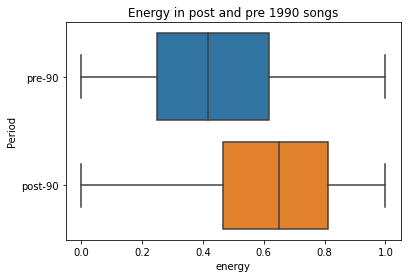

In [33]:
df_data['Period'] = df_data['Year'].map(lambda x: 'pre-90' if x<1990 else 'post-90')
sns.boxplot(x="energy", y="Period", data=df_data)
plt.title('Energy in post and pre 1990 songs');

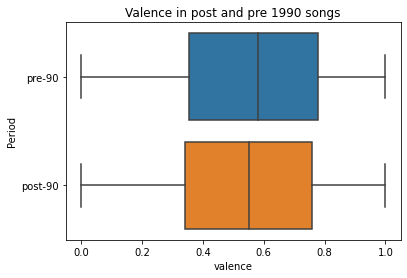

In [34]:
sns.boxplot(x="valence", y="Period", data=df_data)
plt.title('Valence in post and pre 1990 songs');

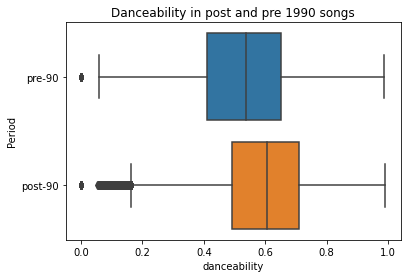

In [35]:
sns.boxplot(x="danceability", y="Period", data=df_data)
plt.title('Danceability in post and pre 1990 songs');

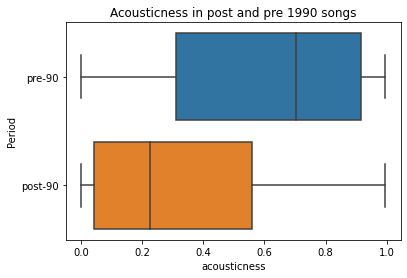

In [36]:
sns.boxplot(x="acousticness", y="Period", data=df_data)
plt.title('Acousticness in post and pre 1990 songs');

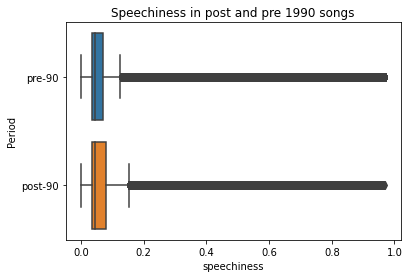

In [37]:
sns.boxplot(x="speechiness", y="Period", data=df_data)
plt.title('Speechiness in post and pre 1990 songs');

As you can see from our results, features like "acousticness" and "energy" seem to be quite different in the two song groups, while the others have similar medians and 1st and 3rd quartile values. One point to look into is "speechiness". In the boxplot above, it seems that both groups have many outliers. Why can that be? Let's split "speechiness" by year first.

In [38]:
import numpy as np
grouped_year = df_data[['Year', 'speechiness']].groupby('Year').agg(np.median)
grouped_year

,speechiness
Year,
1900,0.0295
1922,0.0585
1923,0.9320
1924,0.0801
1925,0.0906
...,...
2017,0.0573
2018,0.0600
2019,0.0612


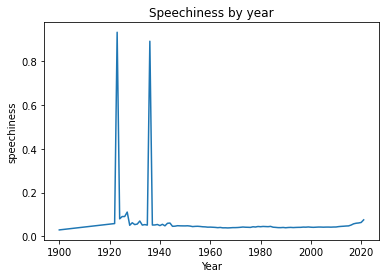

In [39]:
sns.lineplot(data=grouped_year, x="Year", y="speechiness")
plt.title('Speechiness by year');

There seem to have been 2 peaks in speechiness around 1920 and 1935, which might contribute to the appearance of the box plot. Let's also make two histograms that show how the speechiness scores are distributed. Interestingly, below you can see a peak in the speechiness of the pre-90 songs, and even that post-90 songs seem to have a bit of a lower speechiness, given the orange peak at the lower values of the x-axis.

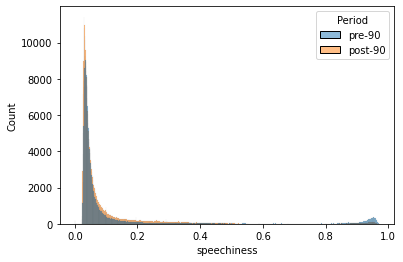

In [40]:
sns.histplot(data=df_data, x='speechiness', hue='Period');

## Visualizing Popularity

In order to have a better idea how popularity affects the audio features, we are going to create some groups to bucket the popularities into: 0-20, 21-40, 41-60, 61-80 and 80+. This should give us a better idea about the effects these groups have on the features.

In [41]:
def bucket_popularity(p):
    if p <= 20:
        return '0-20'
    elif p<=40:
        return '21-40'
    elif p<=60:
        return '41-60'
    elif p<=80:
        return '61-80'
    elif p>80:
        return '80+'
df_data['Bucket_Popularity'] = df_data['popularity'].map(lambda x: bucket_popularity(x))
df_data.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year,Period,Bucket_Popularity
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,...,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922,pre-90,0-20
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,...,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922,pre-90,0-20
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,...,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922,pre-90,0-20
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,...,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922,pre-90,0-20
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,...,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922,pre-90,0-20


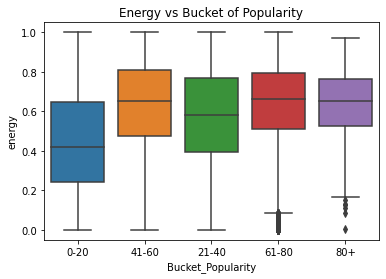

In [42]:
sns.boxplot(data=df_data, x='Bucket_Popularity', y='energy')
plt.title('Energy vs Bucket of Popularity');

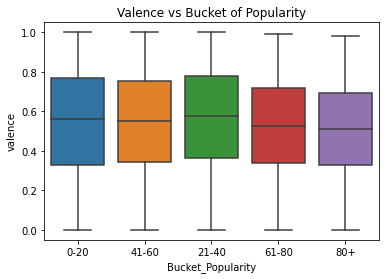

In [43]:
sns.boxplot(data=df_data, x='Bucket_Popularity', y='valence')
plt.title('Valence vs Bucket of Popularity');

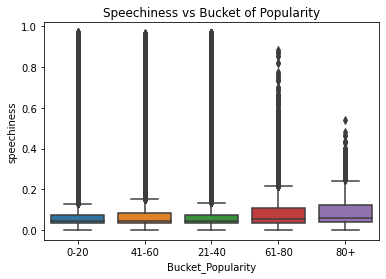

In [44]:
sns.boxplot(data=df_data, x='Bucket_Popularity', y='speechiness')
plt.title('Speechiness vs Bucket of Popularity');

As you can see from the boxplots, there are many outliers in all of the buckets, especially so in the 0-20, 21-40 and 41-60 categories, which also correspond to the lower probabilities. It is interesting to think about the impact that a song's "speechiness" has on its overall popularity.

## Networks of Similar Songs

For this part, I want to build a network of songs based on the similarity of their features. This is going to require using the networkx package, as well as some spatial_distance packages. First, we are going to be using cosine distance to measure the similarity between two songs. Below, there is an example of doing so, as well as taking the useful features for each song in consideration, and only adding a song to another's list of similar songs if the cutoff is at least .95.

In [70]:
import networkx as nx

In [61]:
from scipy import spatial

In [72]:
list_songs = list(sorted_df.name)

In [73]:
sorted_df.iloc[1, :].values[13:20]

array([0.0601, 0.721, 1.31e-05, 0.105, 0.132, 143.874, 4], dtype=object)

In [74]:
spatial.distance.cosine(sorted_df.iloc[1, :].values[13:20], sorted_df.iloc[0, :].values[13:20])

0.00015599575013414135

The code below is filtering out the most similar songs for each song and creating an edges dictionary which will be helpful when building the network.

In [75]:
dict_edges = {}
for i in range(len(list_songs)):
    list_val = []
    for j in range(i):
        a_row = list(sorted_df.iloc[j].values[13:20])
        list_val.append([j, 1 - spatial.distance.cosine(sorted_df.iloc[i].values[13:20], a_row),list(sorted_df.iloc[j].values[13:20])[1] ])
    for j in range(i+1,len(list_songs)):    
        a_row = list(sorted_df.iloc[j].values[13:20])
        list_val.append([j, 1 - spatial.distance.cosine(sorted_df.iloc[i].values[13:20], a_row), list(sorted_df.iloc[j].values[13:20])[1]])
    dict_edges[i] = list_val 
    
    

In [76]:
new_dict = {}
for i in range(100):
    list_to_put = []
    for j in range(len(dict_edges[i])):
        if dict_edges[i][j][1] >= 0.95:
            list_to_put.append(dict_edges[i][j])      
    new_dict[i] = list_to_put

In [93]:
G = nx.Graph()
game_details = ["name"]
for i in range(1):
    for j in range(len(new_dict[i])):
        G.add_node(i,label = i)
        G.add_edge(i, new_dict[i][j][0], weight=int(new_dict[i][j][1]), title = new_dict[i][j][2])

Time to do some visualizations on the data. Below, there is a graph of all of the songs, and their similar songs as defined by our metric.

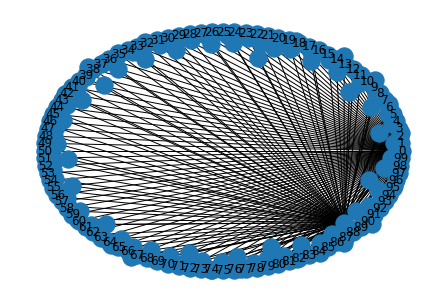

In [94]:
import urllib.request
import io
import zipfile
import matplotlib.pyplot as plt
import networkx as nx


pos = nx.draw_kamada_kawai(G, with_labels=True)  # Seed for reproducible layout
nx.draw(G, pos)
plt.show()

Let's look at which song has the highest similarity to its neighboring songs, as well as what the average degree of this network is, i.e. how many songs is each song similar to on average.

In [95]:
max_deg = 0
node = 0
for n in G.nodes():
    if G.degree[n] > max_deg:
        max_deg = G.degree[n]
        node = n
print(max_deg, node)   

99 0


In [96]:
sum_d = 0
for n in G.nodes():
    sum_d += G.degree[n]
sum_d/len(G.nodes())

1.98

From our results above, it appears that the song that has the highest degree is the following: 'Peaches' by Justin Bieber: a 2021 song.

In [97]:
sorted_df.iloc[0]

id                                             4iJyoBOLtHqaGxP12qzhQI
name                           Peaches (feat. Daniel Caesar & Giveon)
popularity                                                        100
duration_ms                                                    198082
explicit                                                            1
artists                  ['Justin Bieber', 'Daniel Caesar', 'Giveon']
id_artists          ['1uNFoZAHBGtllmzznpCI3s', '20wkVLutqVOYrc0kxF...
release_date                                               2021-03-19
danceability                                                    0.677
energy                                                          0.696
key                                                                 0
loudness                                                       -6.181
mode                                                                1
speechiness                                                     0.119
acousticness        

To visualize how the degree values are distributed among the nodes, we can utilize a degree rank graph as follows. 

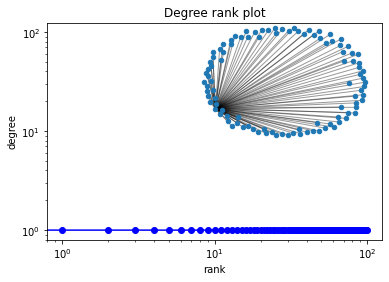

In [98]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
# print "Degree sequence", degree_sequence
dmax = max(degree_sequence)

plt.loglog(degree_sequence, 'b-', marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45, 0.45, 0.45, 0.45])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc)
plt.axis('off')
nx.draw_networkx_nodes(Gcc, pos, node_size=20)
nx.draw_networkx_edges(Gcc, pos, alpha=0.4)

plt.show()

## Scraping the Lyrics Data  

After looking at audio features, we can also examine the lyrics for each song and see how textually similar they are to each other. To do this, we can utilize the LyricsGenius API to get lyrics data for the songs in our data set. I have already done this and will not be repeating the installation process again to not clutter the notebook, but here is a sample of how the process was done.

In [ ]:
song = LyricsGenius.search_song("Missy Elliott", "Work It")

In [ ]:
song.lyrics

In [ ]:
#let's get the lyrics for the songs in our dataset

In [ ]:
#building a list of lists, with each element having Artist_Name and Song_Name:
list_artists_songs = []
lyrics_each = []

In [ ]:
songs_list =  list(df_data.name)
artists_list = list(df_data.artists)

In [ ]:
print(len(songs_list), len(artists_list))

In [ ]:
for i in range(len(songs_list)):
    r1 = re.compile(r"\w{1,20}.\w{1,20}", re.MULTILINE | re.DOTALL)
    r = r1.findall(artists_list[i])
    if len(r) > 0:
        for j in r:
            list_artists_songs.append([songs_list[i], j])

In [ ]:
print(len(list_artists_songs))

In [ ]:
already_chosen = list(pd.read_csv("ChosenAlready").Numbers)

In [ ]:
#make these randomly selected
for i in range(200):
    value = randint(0,915191)
    if value not in already_chosen:
        already_chosen.append(value)
        song = LyricsGenius.search_song(list_artists_songs[value][1], list_artists_songs[value][0])
        if song != None:
            lyrics_each.append(song.lyrics)

In [ ]:
df_old_lyrics_l = list(pd.read_csv('283_SONGS').Text)
new_lyrics = df_old_lyrics_l + lyrics_each

In [ ]:
print(len(new_lyrics))

In [ ]:
df_already = pd.DataFrame(data = {'Numbers': already_chosen})
df_already.to_csv('ChosenAlready', index = False)

In [ ]:
df_lyrics = pd.DataFrame(data = {'Text': df_old_lyrics_l})
df_lyrics.to_csv('400 Songs', index = True)

## Visualization 5: Lyrics Data

Having obtained the data, we can now run text analysis on it. Let's start with analysing polarity and the parts-of-speech composition for the songs.

In [45]:
df_read_lyrics = pd.read_csv('400 Songs')

In [46]:
df_read_lyrics.head()

,Unnamed: 0,Text
0,0,"[Verse]\nI feel so impure\nEvery day, less sur..."
1,1,THE AMERICAN ACADEMY of Emergency Medicine con...
2,2,"[Intro: Young M.A]\nAw man, the squad is here\..."
3,3,All these songs are about (or heavily referenc...
4,4,"[Paroles de ""Respect P. Diddy""]\n\n[Intro : Go..."


We are going to be using TextBlob to calculate the sentiment of the songs as a first step.

In [48]:
from textblob import TextBlob

In [49]:
w = TextBlob(str(df_read_lyrics.iloc[0].Text))

In [50]:
w.sentiment.polarity

0.1047619047619048

In [51]:
list_polarities = []
for i in range(len(df_read_lyrics.index)):
    w = TextBlob(str(df_read_lyrics.iloc[i].Text))
    list_polarities.append(w.sentiment.polarity)

In [52]:
import numpy as np

In [53]:
pol = pd.DataFrame(data = {'Polarity':list_polarities})

In [54]:
np.mean(list_polarities)

0.06915237868895947

In [55]:
pol.head()

,Polarity
0,0.104762
1,0.096368
2,-0.062156
3,0.049851
4,0.066667


Let's visualize the polarities in a histogram, while using the following system to make sense of the score: -1 corresponds to the most negative lyrics, 0 represents neutral lyrics and 1 represents positive ones.

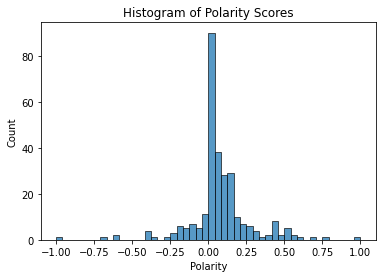

In [16]:
import seaborn as sns

sns.histplot(data=pol, x='Polarity')
plt.title('Histogram of Polarity Scores');

It is clear that the neutral songs are much more common in the dataset. However, I am personally curious to check out the most negative and positive lyrics, so let us do that below as well.

In [56]:
pol['Lyrics'] = df_read_lyrics['Text']
pol.sort_values('Polarity').iloc[0]['Lyrics'][:400]

"Basta pum basta!!!\n\nUma geração que consente deixar-se representar por um Dantas é uma geração que\u2005nunca\u2005o foi. É\u2005um coio d'indigentes, d'indignos e de\u2005cegos! É uma resma de charlatães e de vendidos, e só pode parir abaixo de zero!\n\nAbaixo a geração!\n\nMorra o Dantas, morra! Pim!\n\nUma geração com um Dantas a cavalo é um burro impotente!\nUma geração com um Dantas à proa é uma canoa em seco!\nO Dantas"

In [28]:
pol.sort_values('Polarity', ascending=False).iloc[0]['Lyrics'][:400]

'[Verse 1]\nPare ko, meron akong problema\n\'Wag mong sabihing "na naman?"\nIn love ako sa isang kolehiyala\nHindi ko maintindihan\n\'Wag na nating idaan sa ma-boteng usapan\nLalo lang madaragdagan\nAng sakit ng ulo at bilbil sa tiyan\n\n[Verse 2]\nAnong sarap kami\'y naging magkaibigan\nNapuno ako ng pag-asa\n\'Yun pala, haggang do\'n lang ang kaya\nAkala ko ay pwede pa\n\n[Pre-Chorus]\nMasakit mang isipin\nKailangang '

Interestingly, both of these songs are not in English. To understand whether our analysis is correct, I looked up how TextBlob was actually working behind the scenes and it does seem to have other languages support, even providing some translation methods which are now deprecated. Here is the first text translated from Google Translate:

"Enough bang enough!!!\n\nA generation that consents to allow itself to be represented by a Dantas is a generation that\u2005 never\u2005 was. It\u2005 is a thing of indigents, d'unworthy and\u2005blind! It's a ream of charlatans and of sells, and can only give birth below zero!\n\nDown the generation!\n\nDie Dantas, die! Pim!\n\nA generation with a Dantas on horseback is a powerless ass!\nA generation with a Dantas in the bow it's a dry canoe!\nThe Dantas"


And the second:

'[Verse 1] \ nMy father, I have a problem \ n \' Don't say "again?" \ NI'm in love with a college student \ nI don't understand \ n \ 'Let's not go through bottled conversations \ nEspecially \ nThe headache and stomach ache \ n \ n [Verse 2] \ nWhat a pleasure we have been friends \ nI'm full of hope \ n \ 'That's all, as long as we can \ nI thought I could \ n \ n [Pre-Chorus] \ nIt hurts to think \ nIt's necessary '

We can now proceed with some part of speech tagging:

In [57]:
w = TextBlob(str(df_read_lyrics.iloc[7].Text))

In [35]:
n_perc = []
plural_perc = []
reg_ad_perc = []
comp_ad_perc = []
super_ad_perc = []
verb_perc = []

 
for i in range(len(df_read_lyrics.index)):
    break
    nouns_count = 0
    plural = 0
    reg_adv = 0
    comp_adv = 0 
    super_adv = 0
    verb = 0
    w = TextBlob(str(df_read_lyrics.iloc[i].Text))
    if len(w.tags) <= 10000:
        for j in range(len(w.tags)):
            if w.tags[j][1] == 'NN':
                nouns_count += 1
            if w.tags[j][1] == 'NNS':
                plural += 1
            if w.tags[j][1] == 'RB':
                reg_adv += 1
            if w.tags[j][1] == 'RBS':
                super_adv += 1
            if w.tags[j][1] == 'RBR':
                comp_adv += 1 
            if w.tags[j][1] == 'VB':
                verb += 1  
        print(i, 'Processed')        
        n_perc.append(nouns_count/len(w.tags)) 
        plural_perc.append(plural/len(w.tags)) 
        reg_ad_perc.append(reg_adv/len(w.tags)) 
        comp_ad_perc.append(comp_adv/len(w.tags)) 
        super_ad_perc.append(super_adv/len(w.tags)) 
        verb_perc.append(verb/len(w.tags)) 

In [36]:
len(n_perc)

0

In [ ]:
poly = pd.DataFrame(data = {'Noun_singular':n_perc})

In [ ]:
poly['Noun_singular'] = n_perc
poly['Noun_plural'] = plural_perc
poly['Regular_ad'] = reg_ad_perc
poly['Comp_ad'] = comp_ad_perc
poly['Super_ad'] = super_ad_perc
poly['Verb'] = verb_perc

In [ ]:
poly.to_csv('Metrics', index = True)

I have chosen the parts of speech to be singular and plural nouns, regular, comparative and superlative adjectives and verbs. For each of these, you can see the composition in the table below:

In [39]:
poly = pd.read_csv('Metrics')

In [40]:
poly.head()

,Unnamed: 0,Noun_singular,Noun_plural,Regular_ad,Comp_ad,Super_ad,Verb
0,0,0.215054,0.021505,0.032258,0.010753,0.000000,0.043011
1,1,0.138523,0.031842,0.056788,0.000627,0.000000,0.045380
2,2,0.103575,0.027864,0.006049,0.000183,0.000183,0.006233
3,3,0.369898,0.091837,0.015306,0.000000,0.000000,0.002551
4,4,0.157944,0.009346,0.036449,0.000935,0.000000,0.039252


Let's now visualize these features:

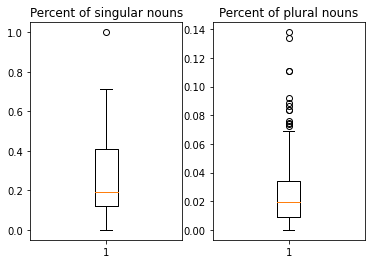

In [60]:
plt.subplot(1, 2, 1)
plt.boxplot(poly['Noun_singular']);
plt.title('Percent of singular nouns');
plt.subplot(1, 2, 2)
plt.boxplot(poly['Noun_plural']);
plt.title('Percent of plural nouns');

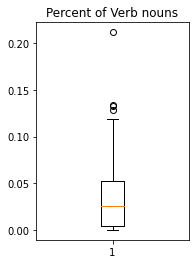

In [61]:
plt.subplot(1, 2, 1)
plt.boxplot(poly['Verb']);
plt.title('Percent of Verb nouns');

Interestingly, it seems like singular nouns make up a large percentage of the songs' lyrics, while the rest of the parts-of-speech less so.

# Geographical Analysis

In this part, I want to do something different. I want to extract some geographical information from the songs' lyrics. How do we do that? I think I am going to start with which cities are the most mentioned in these songs. For this I am going to need a dataframe with names of cities to compare.

In [62]:
df_lyrics = pd.read_csv("400 Songs")
df_lyrics.head()

,Unnamed: 0,Text
0,0,"[Verse]\nI feel so impure\nEvery day, less sur..."
1,1,THE AMERICAN ACADEMY of Emergency Medicine con...
2,2,"[Intro: Young M.A]\nAw man, the squad is here\..."
3,3,All these songs are about (or heavily referenc...
4,4,"[Paroles de ""Respect P. Diddy""]\n\n[Intro : Go..."


We should convert the names of the cities to lower case:

In [63]:
df = pd.read_csv('citynames.txt')

In [64]:
df.head()

,name,country,subcountry,geonameid
0,les Escaldes,Andorra,Escaldes-Engordany,3040051
1,Andorra la Vella,Andorra,Andorra la Vella,3041563
2,Umm al Qaywayn,United Arab Emirates,Umm al Qaywayn,290594
3,Ras al-Khaimah,United Arab Emirates,RaÊ¼s al Khaymah,291074
4,Khawr FakkÄn,United Arab Emirates,Ash ShÄriqah,291696


In [65]:
df['fixed_names'] = df['name'].str.lower()
df.head()

,name,country,subcountry,geonameid,fixed_names
0,les Escaldes,Andorra,Escaldes-Engordany,3040051,les escaldes
1,Andorra la Vella,Andorra,Andorra la Vella,3041563,andorra la vella
2,Umm al Qaywayn,United Arab Emirates,Umm al Qaywayn,290594,umm al qaywayn
3,Ras al-Khaimah,United Arab Emirates,RaÊ¼s al Khaymah,291074,ras al-khaimah
4,Khawr FakkÄn,United Arab Emirates,Ash ShÄriqah,291696,khawr fakkän


Let's clean the lyrics a bit more, and also tokenize them to see if any of the cities appear in the lyrics. As you can see, there are many "\", as well as new line characters.

In [66]:
df_lyrics['Text'].iloc[0]

"[Verse]\nI feel so impure\nEvery day, less sure\nAnd I pour, and I pour\nFrom my hands, from my head\nAnd I wish you were here\nBut you disappeared again\n(Otra vez)\nI'm stuck and motionless\nEmotions drain my heart\nMore blood, more sweat\nA feeling I can regret\n\n[Chorus]\nEvery day, every move's a mistake\nI want to leave this place\nEvery day a waste\nI want to leave this place\nEvery day a waste\nI want to leave this place\nEvery day a waste"

In [67]:
import re

df_lyrics['adjusted_text'] = df_lyrics['Text'].map(lambda x: re.sub(r'\n', ' ', x)).str.lower()
df_lyrics.head()

,Unnamed: 0,Text,adjusted_text
0,0,"[Verse]\nI feel so impure\nEvery day, less sur...","[verse] i feel so impure every day, less sure ..."
1,1,THE AMERICAN ACADEMY of Emergency Medicine con...,the american academy of emergency medicine con...
2,2,"[Intro: Young M.A]\nAw man, the squad is here\...","[intro: young m.a] aw man, the squad is here r..."
3,3,All these songs are about (or heavily referenc...,all these songs are about (or heavily referenc...
4,4,"[Paroles de ""Respect P. Diddy""]\n\n[Intro : Go...","[paroles de ""respect p. diddy""] [intro : goua..."


Now we can check for cities mentioned in the songs, but first we need to tokenize each song's lyrics, and then check if any of the cities in the list are mentioned in a song's tokens. First, notice that there are some other words that signify place inside these tokens: such as "American", or the identity of someone that is related somehow to America. While not directly places, these words could also potentially help us with mapping songs to place.

In [68]:
from nltk.tokenize import word_tokenize
def adding_tokens(x):
    return word_tokenize(x)
df_lyrics['tokenized'] = df_lyrics['adjusted_text'].map(lambda x: adding_tokens(x))
df_lyrics.head()    

,Unnamed: 0,Text,adjusted_text,tokenized
0,0,"[Verse]\nI feel so impure\nEvery day, less sur...","[verse] i feel so impure every day, less sure ...","[[, verse, ], i, feel, so, impure, every, day,..."
1,1,THE AMERICAN ACADEMY of Emergency Medicine con...,the american academy of emergency medicine con...,"[the, american, academy, of, emergency, medici..."
2,2,"[Intro: Young M.A]\nAw man, the squad is here\...","[intro: young m.a] aw man, the squad is here r...","[[, intro, :, young, m.a, ], aw, man, ,, the, ..."
3,3,All these songs are about (or heavily referenc...,all these songs are about (or heavily referenc...,"[all, these, songs, are, about, (, or, heavily..."
4,4,"[Paroles de ""Respect P. Diddy""]\n\n[Intro : Go...","[paroles de ""respect p. diddy""] [intro : goua...","[[, paroles, de, ``, respect, p., diddy, '', ]..."


Now, let's take the first tokenized list to see if there are any matches to cities. And it looks like there aren't. Are there really no songs with mentions of cities in their lyrics? No, obviously we can name a few that have cities in the title, especially songs about New York or Los Angeles. 

In [69]:
list_of_cities = df['fixed_names']
list_of_cities

0            les escaldes
1        andorra la vella
2          umm al qaywayn
3          ras al-khaimah
4           khawr fakkän
               ...       
23013            bulawayo
23014             bindura
23015          beitbridge
23016             epworth
23017         chitungwiza
Name: fixed_names, Length: 23018, dtype: object

In [ ]:
def searching_for_cities(x):
    count = 0
    for word in x:
        if word in list_of_cities:
            count += 1
df_lyrics['tokenized'].map(lambda x: searching_for_cities(x))          

To have a larger dataset of songs, we are going to have to look for one. One way is to write a script that uses LyricsGenius to pull these lyrics.

# Building Models for Predicting Song Popularity

Given all the analysis we have done so far, we might want to put it to use for something practical. One such application could be to build predictors of how well a song is going to do based on its audio features, text attributes and similarity to other songs. So let's get started. First, let's visualize how audio features relate to the popularity scores.

In [3]:
import seaborn as sns

In [4]:
from sklearn.linear_model import LinearRegression

Here is a linear model plot for the "danceability" and the popularity, with a linear regression model fitted. I sampled 5000 songs, since the dataset is too large to feasibly display everything:

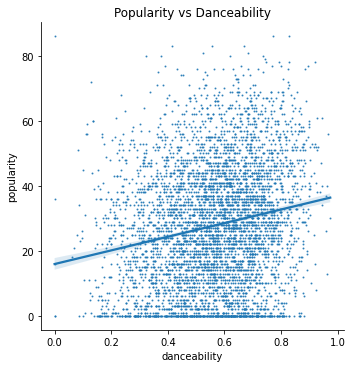

In [5]:
sns.lmplot(x='danceability', y='popularity', data=df_data.sample(5000), fit_reg=True, scatter_kws={"s": 1});
plt.title('Popularity vs Danceability');

For valence, on the other hand, the plot seems to have no linear relationship whatsoever:

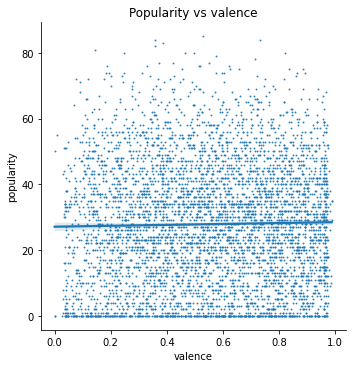

In [6]:
sns.lmplot(x='valence', y='popularity', data=df_data.sample(5000), fit_reg=True, scatter_kws={"s": 1});
plt.title('Popularity vs valence');

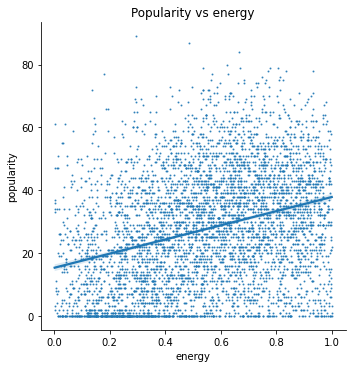

In [7]:
sns.lmplot(x='energy', y='popularity', data=df_data.sample(5000), fit_reg=True, scatter_kws={"s": 1});
plt.title('Popularity vs energy');

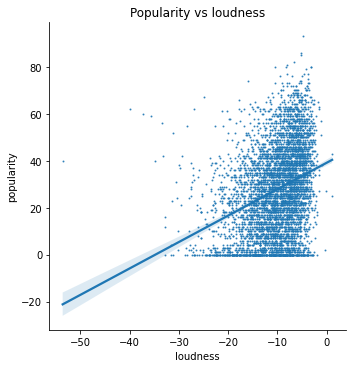

In [8]:
sns.lmplot(x='loudness', y='popularity', data=df_data.sample(5000), fit_reg=True, scatter_kws={"s": 1});
plt.title('Popularity vs loudness');

## Fitting a Linear Model and Finding the Optimal Parameters

We can finally start with fitting a linear model:

In [3]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas as pd

In [4]:
df_data.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


Let's check that the assumptions of the linear regression model hold, starting with normality:

For the time being, let's only select the numerical features of the data, meaning the audio features:

In [5]:
X = df_data[['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
      'instrumentalness', 'liveness', 'valence', 'tempo']]

##### Checking the Assumptions of the Linear Regression Model: Normalitty

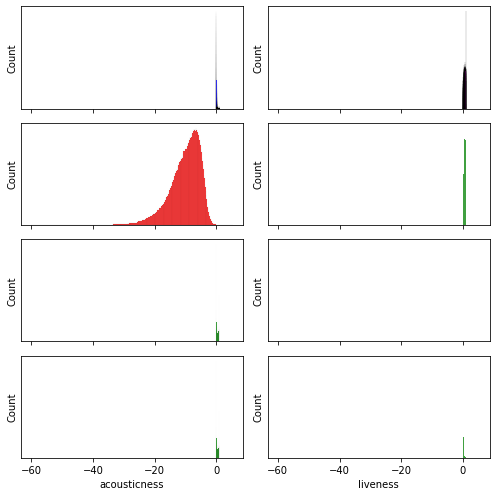

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

f, axes = plt.subplots(4, 2, figsize=(7, 7), sharex=True)

# Plot a simple distribution of the desired columns
sns.histplot(data = X, x ="speechiness", color="b", ax=axes[0, 0])
sns.histplot(data = X, x = "valence", color="m", ax=axes[0, 1])
sns.histplot(data = X, x = "loudness", color="r", ax=axes[1, 0])
sns.histplot(data = X, x = "energy", color="g", ax=axes[1, 1])
sns.histplot(data = X, x = "acousticness", color="g", ax=axes[2, 0])
sns.histplot(data = X, x = "instrumentalness", color="g", ax=axes[2, 1])
sns.histplot(data = X, x = "acousticness", color="g", ax=axes[3, 0])
sns.histplot(data = X, x = "liveness", color="g", ax=axes[3, 1])


plt.setp(axes, yticks=[])
plt.tight_layout()

### Log Transformation

So our data is not looking normal at all, from a quick qualitative check. One good idea to implement would be to apply a log transformation to the features in order to make them normal.

<AxesSubplot:xlabel='log trans speech', ylabel='Count'>

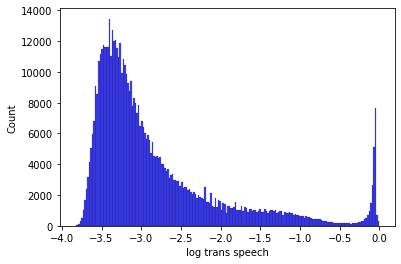

In [7]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
X['log trans speech'] = X['speechiness'].map(lambda x: np.log(x) if x!=0 else 0)
sns.histplot(data = X, x ="log trans speech", color="b")

<AxesSubplot:xlabel='log trans valence', ylabel='Count'>

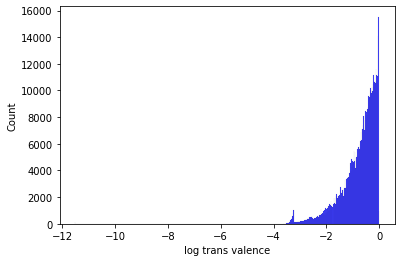

In [8]:
X['log trans valence'] = X['valence'].map(lambda x: np.log(x) if x!=0 else 0)
sns.histplot(data = X, x ="log trans valence", color="b")

<AxesSubplot:xlabel='log trans loudness', ylabel='Count'>

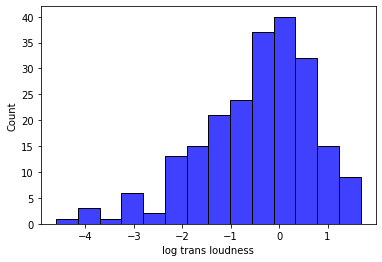

In [9]:
X['log trans loudness'] = X['loudness'].map(lambda x: np.log(x) if x!=0 else 0)
sns.histplot(data = X, x ="log trans loudness", color="b")

<AxesSubplot:xlabel='log trans energy', ylabel='Count'>

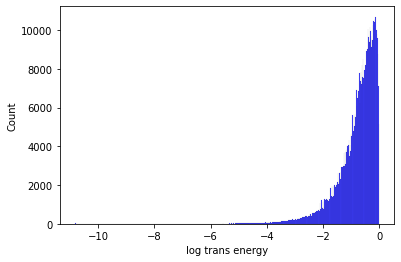

In [10]:
X['log trans energy'] = X['energy'].map(lambda x: np.log(x) if x!=0 else 0)
sns.histplot(data = X, x ="log trans energy", color="b")

<AxesSubplot:xlabel='log trans duration', ylabel='Count'>

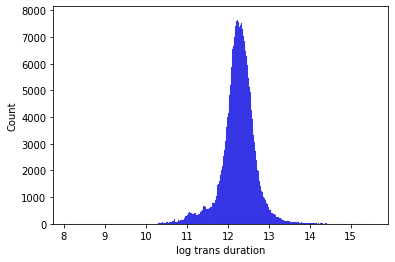

In [11]:
X['log trans duration'] = X['duration_ms'].map(lambda x: np.log(x) if x!=0 else 0)
sns.histplot(data = X, x ="log trans duration", color="b")

<AxesSubplot:xlabel='log trans dance', ylabel='Count'>

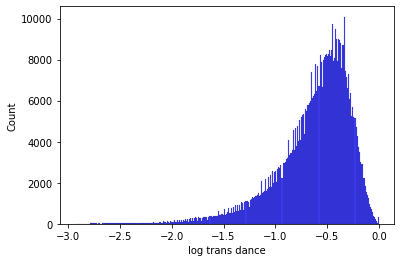

In [12]:
X['log trans dance'] = X['danceability'].map(lambda x: np.log(x) if x!=0 else 0)
sns.histplot(data = X, x ="log trans dance", color="b")

<AxesSubplot:xlabel='log trans acoustic', ylabel='Count'>

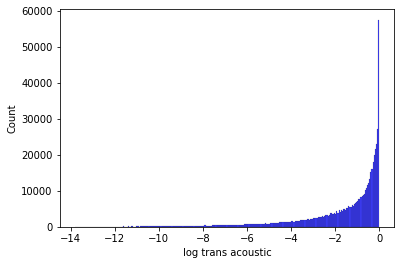

In [13]:
X['log trans acoustic'] = X['acousticness'].map(lambda x: np.log(x) if x!=0 else 0)
sns.histplot(data = X, x ="log trans acoustic", color="b")

<AxesSubplot:xlabel='log trans live', ylabel='Count'>

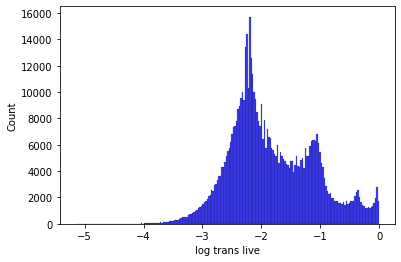

In [14]:
X['log trans live'] = X['liveness'].map(lambda x: np.log(x) if x!=0 else 0)
sns.histplot(data = X, x ="log trans live", color="b")

So we see that some of our log-transformed features seem to approximate a normal distribution, especially the "duration" and to some extent the "loudness". Let's remove some outliers from the data, so that we can bring the others to fit a normal distribution as well. We will do this for the danceability and the speechiness columns.

### Dealing with Outliers

In [15]:
# danceability

In [16]:
X['log trans dance'].describe()

count    586672.000000
mean         -0.626925
std           0.356781
min          -2.933697
25%          -0.791863
50%          -0.549913
75%          -0.376878
max           0.000000
Name: log trans dance, dtype: float64

Let's remove the songs that fall outside of 1.5*IQR (the interquartile range) of the danceability:

In [17]:
negative_iqr = -0.549913 - (-0.376878+0.791863)*1.5
positive_iqr = -0.549913 + (-0.376878+0.791863)*1.5
X_no_outliers = X[(X['log trans dance'] <= positive_iqr) & (X['log trans dance'] >= negative_iqr)]

<AxesSubplot:xlabel='log trans dance', ylabel='Count'>

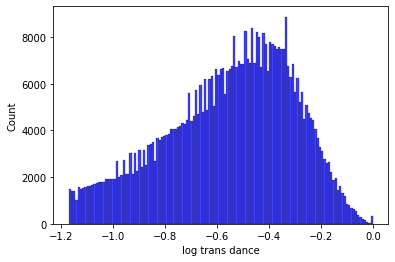

In [18]:
sns.histplot(data = X_no_outliers, x ="log trans dance", color="b")

In [19]:
# speechiness

In [20]:
X_no_outliers['log trans speech'].describe()

count    540788.000000
mean         -2.785958
std           0.873525
min          -3.835062
25%          -3.381395
50%          -3.096658
75%          -2.524479
max           0.000000
Name: log trans speech, dtype: float64

In [21]:
negative_iqr = -3.096658 - (-2.524479+3.381395)*1.5
positive_iqr = -3.096658 + (-2.524479+3.381395)*1.5
X_no_outliers = X_no_outliers[(X_no_outliers['log trans speech'] <= positive_iqr) & (X_no_outliers['log trans speech'] >= negative_iqr)]

<AxesSubplot:xlabel='log trans speech', ylabel='Count'>

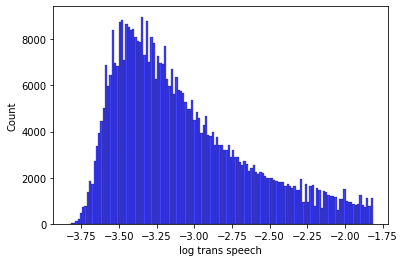

In [22]:
sns.histplot(data = X_no_outliers, x ="log trans speech", color="b")

In [23]:
# acousticness

In [24]:
X['log trans acoustic'].describe()

count    586672.000000
mean         -1.697142
std           2.127734
min         -13.815511
25%          -2.333044
50%          -0.862750
75%          -0.242072
max           0.000000
Name: log trans acoustic, dtype: float64

In [25]:
negative_iqr = -0.862750 - (-0.242072+2.333044)*1.5
positive_iqr = -3.096658 + (-0.242072+2.333044)*1.5
X_no_outliers = X_no_outliers[(X_no_outliers['log trans acoustic'] <= positive_iqr) & (X_no_outliers['log trans acoustic'] >= negative_iqr)]

<AxesSubplot:xlabel='log trans acoustic', ylabel='Count'>

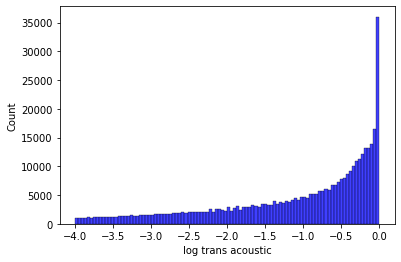

In [26]:
sns.histplot(data = X_no_outliers, x ="log trans acoustic", color="b")

In [27]:
#liveness

In [28]:
X_no_outliers['log trans live'].describe()

count    406134.000000
mean         -1.877159
std           0.688862
min          -5.163786
25%          -2.340287
50%          -2.032558
75%          -1.394327
max           0.000000
Name: log trans live, dtype: float64

In [29]:
negative_iqr = -2.032558 - (-1.394327+2.340287)*1.5
positive_iqr = -2.032558 + (-1.394327+2.340287)*1.5
X_no_outliers = X_no_outliers[(X_no_outliers['log trans live'] <= positive_iqr) & (X_no_outliers['log trans live'] >= negative_iqr)]

### Checking Multicollinearity

<AxesSubplot:>

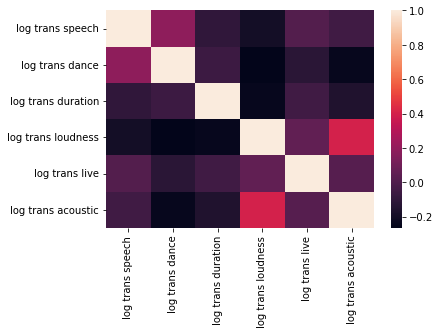

In [30]:
sns.heatmap(data = X_no_outliers[['log trans speech', 'log trans dance'
                                  , 'log trans duration', 'log trans loudness', 
                                 'log trans live', 'log trans acoustic']].corr())

It doesn't appear that any of our features are strongly correlated to each-other, as the linear model assumes, so we can proceed.

### Fitting the Model: Linear Regression

In [31]:
model = LinearRegression(fit_intercept=True)

X_no_outliers_model = X_no_outliers[['log trans speech', 'log trans dance'
                                  , 'log trans duration', 'log trans loudness', 
                                 'log trans live', 'log trans acoustic']]

X_dropped = X_no_outliers_model.dropna()

y = df_data.loc[X_dropped.index, 'popularity']
model.fit(X_dropped, y)

LinearRegression()

In [32]:
y_preds = model.predict(X_dropped)

Let's qualitatively examine the plot of the predicted y versus the real y values.

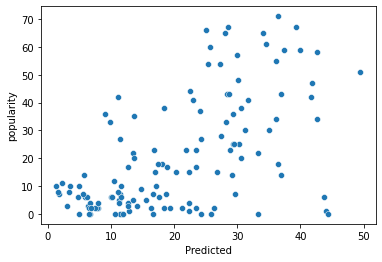

In [33]:
df_y_ypred = pd.DataFrame(data={'Y':y, 'Predicted': y_preds}, index=y)
sns.scatterplot(data=df_y_ypred, x='Predicted', y='popularity');

Let's try to understand these predictions using metrics now:

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [39]:
mean_squared_error(y, y_preds)

266.64483397101714

In [40]:
mean_absolute_error(y, y_preds)

12.40898957243052

In [41]:
r2_score(y, y_preds)

0.340880153380248

### Feature Engineering

Another feature we might want to model might relate to the publication date for a song. As we examined in the first part of this project, we have some data relating to the publication year. In the plot below, we can see that an increasing year generally leads to an increase in popularity, so we can work that into our model as well:

In [93]:
years = df_data['release_date'].map(lambda x: x[:4])
df_data['year'] = years

<AxesSubplot:xlabel='year', ylabel='popularity'>

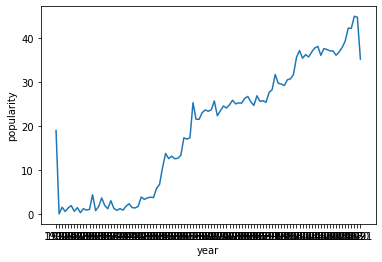

In [94]:
sns.lineplot(data=df_data.groupby('year').mean(), x='year', y='popularity')

In [96]:
df_data['earliness'] = df_data['year'].map(lambda x: int(x) - 2000)
column_year = df_data.loc[X_dropped.index, 'earliness']
X_dropped['earliness'] = column_year

Now, let's try to add some more features to the model. One feature we looked at was song similarity, i.e. how similar a song was to the others, and we visualized them using networkx. We can create a metric to measure this, and add it to our model:

In [74]:
dict_edges = {}
for i in range(len(X_dropped)):
    list_val = []
    for j in range(i):
        a_row = list(X_dropped.iloc[j].values[0:5])
        list_val.append([j, 1 - spatial.distance.cosine(X_dropped.iloc[i].values[0:5], a_row),list(X_dropped.iloc[j].values[0:5])[1]])
    dict_edges[i] = list_val 
    
new_dict = {}
for i in range(len(dict_edges)):
    list_to_put = []
    for j in range(len(dict_edges[i])):
        if dict_edges[i][j][1] >= 0.95:
            list_to_put.append(dict_edges[i][j])      
    new_dict[i] = len(list_to_put)

In [86]:
X_dropped['proximity_others'] = new_dict.values()

#### Fitting the Model with the New Features 

In [97]:
model_features = LinearRegression(fit_intercept=True)

y = df_data.loc[X_dropped.index, 'popularity']
model_features.fit(X_dropped, y)

LinearRegression()

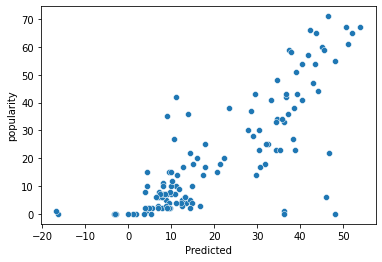

In [98]:
y_preds = model_features.predict(X_dropped)
df_y_ypred = pd.DataFrame(data={'Y':y, 'Predicted': y_preds}, index=y)
sns.scatterplot(data=df_y_ypred, x='Predicted', y='popularity');

In [99]:
mean_squared_error(y, y_preds)

145.900482529075

In [100]:
r2_score(y, y_preds)

0.639348333758589

Interestingly, now that we fit a couple more features, the mean squared error fell dramatically, and the r2 also rose by a great amount, which is a great improvement over our initial model.

### Fitting a Non-Parametric Model: KNN Regression

In addition to the parametric method we just fitted to our data, we can also attempt to fit a non-parametric model, starting with KNN Regression:

In [101]:
from sklearn.neighbors import KNeighborsRegressor

In [102]:
non_param_model = KNeighborsRegressor()
non_param_model.fit(X_dropped, y)
y_pred_nonparam = non_param_model.predict(X_dropped)

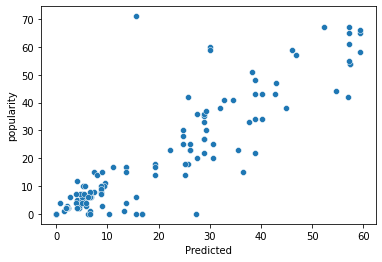

In [103]:
df_y_ypred = pd.DataFrame(data={'Y':y, 'Predicted': y_pred_nonparam}, index=y)
sns.scatterplot(data=df_y_ypred, x='Predicted', y='popularity');

In [104]:
mean_squared_error(y, y_pred_nonparam)

85.89374999999998

In [105]:
r2_score(y, y_pred_nonparam)

0.7876790842617676

So we can see that our mean squared error went down, compared to the linear model and the r2 score went up. Both of these are improvements, so let's try cros-validation on this model and see how it performs.

## Cross-Validation

The scoring metrics for the KNN Regression model will be r2 and the negative mean squared error:

In [106]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(non_param_model, X_dropped, y, scoring='neg_mean_squared_error', cv=5))

[-433.22       -310.50153846  -73.70461538  -45.9168      -37.0928    ]


In [107]:
print(cross_val_score(non_param_model, X_dropped, y, scoring='r2', cv=5))

[-0.23616222  0.36607268  0.82604273  0.85171598  0.88826177]


Which is the optimal number of folds to choose for performing cross-validation?

In [108]:
mean_nonparam = []
indices = []
data_non = {}
for i in range(2,11):
    mean_nonparam = []
    mean_nonparam.append(cross_val_score(non_param_model, X_dropped, y, scoring='neg_mean_squared_error', cv=i))
    data_non[i] = np.mean(mean_nonparam)

In [110]:
df_nonparam = pd.DataFrame(data = data_non, index=data_non.keys())
df_nonparam.head()

,2,3,4,5,6,7,8,9,10
2,-254.811563,-263.006142,-367.669687,-180.087151,-155.923766,-250.305079,-234.616562,-178.382392,-199.729
3,-254.811563,-263.006142,-367.669687,-180.087151,-155.923766,-250.305079,-234.616562,-178.382392,-199.729
4,-254.811563,-263.006142,-367.669687,-180.087151,-155.923766,-250.305079,-234.616562,-178.382392,-199.729
5,-254.811563,-263.006142,-367.669687,-180.087151,-155.923766,-250.305079,-234.616562,-178.382392,-199.729
6,-254.811563,-263.006142,-367.669687,-180.087151,-155.923766,-250.305079,-234.616562,-178.382392,-199.729


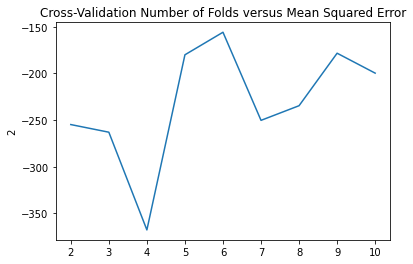

In [116]:
sns.lineplot(data=df_nonparam.T, x=df_nonparam.T.index, y=2);
plt.title('Cross-Validation Number of Folds versus Mean Squared Error');

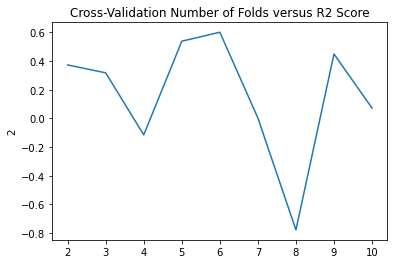

In [118]:
data_non = {}
for i in range(2,11):
    r2_nonparam = []
    r2_nonparam.append(cross_val_score(non_param_model, X_dropped, y, scoring='r2', cv=i))
    data_non[i] = np.mean(r2_nonparam)
    
df_nonparam = pd.DataFrame(data = data_non, index=data_non.keys())
sns.lineplot(data=df_nonparam.T, x=df_nonparam.T.index, y=2);
plt.title('Cross-Validation Number of Folds versus R2 Score'); 